# 使用最新特征



In [1]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
other_feat_df = pd.read_table('../../allFeature.csv/allFeature.csv',sep=' ')


train_df = other_feat_df[other_feat_df['day'] < 24]
train_df = train_df[~train_df['is_trade'].isnull()]
test_df = other_feat_df[other_feat_df['day'] == 24]
test_df = test_df[~test_df['is_trade'].isnull()]

X_train = train_df.drop(['is_trade'], axis=1)
X_test = test_df.drop(['is_trade'], axis=1)
y_train = train_df[['is_trade']].values.ravel()
y_test = test_df[['is_trade']].values.ravel()
print(train_df.shape, test_df.shape)



(420669, 103) (57415, 103)


In [2]:
import xgboost
from sklearn.model_selection import ParameterGrid
#import lightgbm as lgb


# y_test is already exists
# 训练模型
from sklearn.metrics import log_loss


params = {
    'n_jobs':[7],
    'max_depth':[3],
    'n_estimators':[100],
    'min_child_weight':[5],
    'gamma':[5],
    'learning_rate':[0.05],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'gamma':[0],
    'objective':['binary:logistic'],
    'reg_alpha':[1]
}

# 进入测试阶段
xgb = xgboost.XGBClassifier(n_jobs=7)
for g in ParameterGrid(params):
    print('>', '- '*40, '\n\n> ', g, '\n')    
    xgb.set_params(**g)
    m = xgb.fit(X_train, y_train)
    train_loss = log_loss(y_train, m.predict_proba(X_train))*100000
    test_loss  = log_loss(y_test, m.predict_proba(X_test))*100000
    print('> %.0f_%.0f\n' % \
          (train_loss, test_loss))

> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

>  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'n_jobs': 7, 'objective': 'binary:logistic', 'reg_alpha': 1, 'subsample': 0.8} 

> 9267_8535



# 使用别人特征
1. 使用我的验证方式来验证

In [7]:
from collections import Counter
help(Counter)

Help on class Counter in module collections:

class Counter(builtins.dict)
 |  Dict subclass for counting hashable items.  Sometimes called a bag
 |  or multiset.  Elements are stored as dictionary keys and their counts
 |  are stored as dictionary values.
 |  
 |  >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
 |  
 |  >>> c.most_common(3)                # three most common elements
 |  [('a', 5), ('b', 4), ('c', 3)]
 |  >>> sorted(c)                       # list all unique elements
 |  ['a', 'b', 'c', 'd', 'e']
 |  >>> ''.join(sorted(c.elements()))   # list elements with repetitions
 |  'aaaaabbbbcccdde'
 |  >>> sum(c.values())                 # total of all counts
 |  15
 |  
 |  >>> c['a']                          # count of letter 'a'
 |  5
 |  >>> for elem in 'shazam':           # update counts from an iterable
 |  ...     c[elem] += 1                # by adding 1 to each element's count
 |  >>> c['a']                          # now there are seven 'a'
 |  7
 

In [ ]:
Counter(other_feat_df.is_trade.values)

In [25]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%run ../util/base_frame.py

train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
# test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')
test_df = pd.read_table('../../round1_ijcai_18_test_b_20180418.txt',sep=' ')

fa = BaseFrame(train_df, test_df, 6)

In [26]:
other_feat_df = pd.read_table('../../allFeature.csv/allFeature.csv',sep=' ')
fa.df = pd.merge(fa.df[['context_id']], other_feat_df, how='left', on='context_id')
fa.df['data_set'] = fa.df.is_trade.map(lambda x: 'training' if x >= 0 else 'testing')
print(fa.df.shape)

(478138, 104)


# 3 训练

In [ ]:
fa.y_test

In [ ]:
import xgboost
from sklearn.model_selection import ParameterGrid
#import lightgbm as lgb
%run ../util/base_frame.py

params = {
    'n_jobs':[7],
    'max_depth':[3],
    'n_estimators':[100],
    'min_child_weight':[5],
    'gamma':[5],
    'learning_rate':[0.05],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'gamma':[0],
    'objective':['binary:logistic'],
    'reg_alpha':[1]
}

xgb = None

xgb = xgboost.XGBClassifier(n_jobs=7)
for g in ParameterGrid(params):
    xgb.set_params(**g)
    print('>', '- '*40, '\n\n> ', g, '\n')
    train_df = fa.df[fa.df['data_set'] == 'training']
    test_df = fa.df[fa.df['data_set'] == 'testing']

    X_train = None 
    X_test = None 
    X_train = train_df.drop([] + ['data_set'], axis=1)
    X_test = test_df.drop([] + ['data_set'], axis=1)
    if 'date' in train_df.columns and 'date' in test_df.columns:
        X_train = train_df.drop([] + ['date'], axis=1)
        X_test = test_df.drop([] + ['date'], axis=1)        
            
    y_train = train_df[['is_trade']].values.ravel()
    y_test = test_df[['is_trade']].values.ravel()
    m = xgb.fit(X_train, y_train)
    # 分离a,b榜
    train_loss = log_loss(y_train, m.predict_proba(X_train))*100000
    test_loss  = log_loss(y_test, m.predict_proba(X_test))*100000
    print('> %.0f_%.0f\n' % \
          (train_loss, test_loss))

In [33]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(478111, 103) (478111,) (27, 103) (27,)


# 调研他的代码

In [37]:
import scipy.special as special
from collections import Counter
import pandas as pd 
import time
def timestamp_datetime(value):
        format = '%Y-%m-%d %H:%M:%S'
        value = time.localtime(value)
        dt = time.strftime(format, value)
        return dt
    
def readData():
    test = pd.read_csv('../../round1_ijcai_18_test_a_20180301.txt', sep = ' ')   
    train = pd.read_csv('../../round1_ijcai_18_train_20180301.txt', sep = ' ')
    train.drop_duplicates(inplace = True)
    key = list( test )
    print(key)
    mergeData = pd.concat([train, test], keys = key)
    mergeData = mergeData.reset_index( drop = True )
    mergeData['time'] = mergeData.context_timestamp.apply(timestamp_datetime)
    mergeData['day'] = mergeData.time.apply(lambda x: int(x[8:10]))
    mergeData['hour'] = mergeData.time.apply(lambda x: int(x[11:13]))
    mergeData['minute'] = mergeData.time.apply(lambda x: int(x[14:16]))
    return mergeData

merge_df = readData()

['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']


In [39]:
merge_df

,context_id,context_page_id,context_timestamp,instance_id,is_trade,item_brand_id,item_category_list,item_city_id,item_collected_level,item_id,...,shop_star_level,user_age_level,user_gender_id,user_id,user_occupation_id,user_star_level,time,day,hour,minute
0,282924576738839389,4006,1537236544,108641074714126964,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1003,1,4505772604969228686,2005,3003,2018-09-18 10:09:04,18,10,9
1,4007979028023783431,4001,1537243232,5754713551599725161,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1002,0,2692638157208937547,2005,3006,2018-09-18 12:00:32,18,12,0
2,4884875192608989870,4001,1537211052,842679481291040981,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1003,0,5247924392014515924,2005,3004,2018-09-18 03:04:12,18,3,4
3,840119421106178602,4016,1537222670,937088850059189027,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1004,1,2681414445369714628,2005,3006,2018-09-18 06:17:50,18,6,17
4,1736769971710354684,4001,1537271320,7975697065017708072,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1002,0,2729475788342039013,2005,3001,2018-09-18 19:48:40,18,19,48
5,4434980272230296456,4003,1537282855,7764762765372067286,0.0,1975590437749032870,7908382889764677758;5799347067982556520,3948283326616421003,4,3412720377098676069,...,5002,1004,1,4512655448325954611,2005,3002,2018-09-18 23:00:55,18,23,0
6,3622211816051289512,4001,1537280317,6956333474094867789,0.0,9057103201734987852,7908382889764677758;8277336076276184272,548352491538518780,8,285660928590172217,...,5012,1006,1,8811056487516803043,2005,3000,2018-09-18 22:18:37,18,22,18
7,7851031132945961016,4001,1537261120,8387099821892927911,0.0,9057103201734987852,7908382889764677758;8277336076276184272,548352491538518780,8,285660928590172217,...,5012,1002,0,6507704883896466138,2002,3002,2018-09-18 16:58:40,18,16,58
8,8388974876851097582,4001,1537208871,4021878205550012615,0.0,5520678735822176314,7908382889764677758;5755694407684602296,548352491538518780,10,5202355029344881809,...,5012,1003,0,6203308008480593423,2002,3007,2018-09-18 02:27:51,18,2,27
9,1138535512266486347,4003,1537285390,6499571365974135517,0.0,9057103201734987852,7908382889764677758;8277336076276184272,548352491538518780,8,285660928590172217,...,5012,1003,0,6041712044514783312,2005,3006,2018-09-18 23:43:10,18,23,43


In [ ]:
%run ../util/BrandIDBayesSmooth.py


In [47]:
%run ../util/userIDBayesSmooth.py


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.853476687842 41.455709224
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothUserCVR'] = PH_user_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.12520231044 55.2939856049
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.984594748331 48.457967926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.02853339139 50.9925884934
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.04772468487 52.8343365855
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.998830927426 51.0217884086
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothUserCVR'] = PH_user_id


In [48]:
%run ../util/main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py


item_category_list_ing
item_property_list_ing
predict_category_property_ing_0
---------------------------
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num

G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.853476687842 41.455709224
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothUserCVR'] = PH_user_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.12520231044 55.2939856049
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.984594748331 48.457967926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.02853339139 50.9925884934
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.04772468487 52.8343365855
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.998830927426 51.0217884086
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.28777367113 114.69545676
20day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothBrandCVR'] = PH_Brand_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.16994820949 109.86178694
21day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.05518063183 103.43517261
22day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03308345807 102.114422124
23day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03306416956 102.839059432
24day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.07192354781 105.500860638
25day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.99240079132 96.492758926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.87392654619 92.7017838931
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89587730827 93.0289475579
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.88590609191 92.8673450753
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89745111781 94.1775942228
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.91197830814 95.8370424614
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothShopCVR'] = PH_shop_id
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['user_id_order'] = rnColumn['context_timestamp']


list =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sales_level', 'item_ID_sales_level', 'item_ID_collected_level', 'item_category_price_level', 'predict_category_property0', 'predict_category_property1', 'predict_category_property2', 'predict_category_property3', 'predict_category

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cnt1'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cnt1'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 data =  (539370, 76)
first list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sa

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cntx'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cntx'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1-1 Df2 =  (78261, 7)
len2-1 Df2 =  (149188, 7)
len2-1 Df2 =  (217572, 7)
len2-1 Df2 =  (288767, 7)
len2-1 Df2 =  (357082, 7)
len2-1 Df2 =  (420693, 7)
len2-1 Df2 =  (478111, 7)
len2-1 Df2 =  (539370, 7)
len3-1 Df2 =  (539370, 84)
second list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id',

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_item_cnt2'] = df2[['item_id', 'user_id']].apply(lambda x: user_item_cnt.get(tuple(x), 0), axis=1)
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cnt2'] = df2['user_id'].apply(lambda x: user_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 Df2 =  (539370, 7)
list Df2 ['user_item_cnt2', 'user_cnt2', 'item_cnt2', 'shop_cnt2', 'item_id', 'user_id', 'instance_id']
data shape (539370, 88)


In [ ]:
ad_data = evalModel()

In [51]:
################
# 训练得出测试结果
baseline =  0.0787732
model = solution('eval')
ad_data = model.readData()
ad_data = model.convert_data(ad_data)
data, target = model.datafilter(ad_data)
#testFeature = 'testfeature0419.csv'
#data.to_csv(testFeature, sep=" ", index=False, line_terminator='\r')
#model.writeFeature(data)

# model.modelFiveFoldEval(data, target)
# model.modelDayEval(data, target)

item_category_list_ing
item_property_list_ing
predict_category_property_ing_0
---------------------------
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num

G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.853476687842 41.455709224
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothUserCVR'] = PH_user_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.12520231044 55.2939856049
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.984594748331 48.457967926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.02853339139 50.9925884934
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.04772468487 52.8343365855
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.998830927426 51.0217884086
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.28777367113 114.69545676
20day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothBrandCVR'] = PH_Brand_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.16994820949 109.86178694
21day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.05518063183 103.43517261
22day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03308345807 102.114422124
23day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03306416956 102.839059432
24day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.07192354781 105.500860638
25day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.99240079132 96.492758926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.87392654619 92.7017838931
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89587730827 93.0289475579
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.88590609191 92.8673450753
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89745111781 94.1775942228
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.91197830814 95.8370424614
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothShopCVR'] = PH_shop_id
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['user_id_order'] = rnColumn['context_timestamp']


list =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sales_level', 'item_ID_sales_level', 'item_ID_collected_level', 'item_category_price_level', 'predict_category_property0', 'predict_category_property1', 'predict_category_property2', 'predict_category_property3', 'predict_category

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cnt1'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cnt1'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 data =  (539370, 76)
first list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sa

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cntx'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cntx'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1-1 Df2 =  (78261, 7)
len2-1 Df2 =  (149188, 7)
len2-1 Df2 =  (217572, 7)
len2-1 Df2 =  (288767, 7)
len2-1 Df2 =  (357082, 7)
len2-1 Df2 =  (420693, 7)
len2-1 Df2 =  (478111, 7)
len2-1 Df2 =  (539370, 7)
len3-1 Df2 =  (539370, 84)
second list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id',

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_item_cnt2'] = df2[['item_id', 'user_id']].apply(lambda x: user_item_cnt.get(tuple(x), 0), axis=1)
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cnt2'] = df2['user_id'].apply(lambda x: user_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 Df2 =  (539370, 7)
list Df2 ['user_item_cnt2', 'user_cnt2', 'item_cnt2', 'shop_cnt2', 'item_id', 'user_id', 'instance_id']
data shape (539370, 88)


G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:1326: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  day19_23 = day18_23[data['day'] >= 18]


NameError: name 'lgb' is not defined

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


[0]	train-logloss:0.648026	test-logloss:0.647867
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 150 rounds.
[1]	train-logloss:0.607206	test-logloss:0.606887
[2]	train-logloss:0.570114	test-logloss:0.569656
[3]	train-logloss:0.536276	test-logloss:0.535664
[4]	train-logloss:0.505287	test-logloss:0.504523
[5]	train-logloss:0.476865	test-logloss:0.475926
[6]	train-logloss:0.4507	test-logloss:0.449617
[7]	train-logloss:0.426582	test-logloss:0.425384
[8]	train-logloss:0.404293	test-logloss:0.40296
[9]	train-logloss:0.383654	test-logloss:0.382196
[10]	train-logloss:0.364493	test-logloss:0.362878
[11]	train-logloss:0.346716	test-logloss:0.344969
[12]	train-logloss:0.330184	test-logloss:0.328305
[13]	train-logloss:0.31479	test-logloss:0.312757
[14]	train-logloss:0.300467	test-logloss:0.298275
[15]	train-logloss:0.287102	test-logloss:0.284762
[16]	train-logloss:0.274621	test-logloss:0.272158
[17]	train-log

[161]	train-logloss:0.086699	test-logloss:0.07992
[162]	train-logloss:0.086677	test-logloss:0.079901
[163]	train-logloss:0.086648	test-logloss:0.079888
[164]	train-logloss:0.086616	test-logloss:0.079863
[165]	train-logloss:0.086591	test-logloss:0.079856
[166]	train-logloss:0.086571	test-logloss:0.079848
[167]	train-logloss:0.086547	test-logloss:0.079839
[168]	train-logloss:0.086533	test-logloss:0.079831
[169]	train-logloss:0.086518	test-logloss:0.079799
[170]	train-logloss:0.086501	test-logloss:0.07979
[171]	train-logloss:0.086475	test-logloss:0.079773
[172]	train-logloss:0.086458	test-logloss:0.079761
[173]	train-logloss:0.086433	test-logloss:0.079746
[174]	train-logloss:0.086407	test-logloss:0.07971
[175]	train-logloss:0.086388	test-logloss:0.079696
[176]	train-logloss:0.086364	test-logloss:0.079683
[177]	train-logloss:0.086345	test-logloss:0.079672
[178]	train-logloss:0.086328	test-logloss:0.079667
[179]	train-logloss:0.086309	test-logloss:0.079653
[180]	train-logloss:0.086286	test-

[323]	train-logloss:0.084653	test-logloss:0.079022
[324]	train-logloss:0.084641	test-logloss:0.079021
[325]	train-logloss:0.08463	test-logloss:0.079016
[326]	train-logloss:0.084621	test-logloss:0.079016
[327]	train-logloss:0.084615	test-logloss:0.079016
[328]	train-logloss:0.084603	test-logloss:0.079008
[329]	train-logloss:0.084595	test-logloss:0.079007
[330]	train-logloss:0.084588	test-logloss:0.079002
[331]	train-logloss:0.084581	test-logloss:0.078997
[332]	train-logloss:0.084569	test-logloss:0.078999
[333]	train-logloss:0.084561	test-logloss:0.079006
[334]	train-logloss:0.084556	test-logloss:0.079007
[335]	train-logloss:0.08455	test-logloss:0.079004
[336]	train-logloss:0.084539	test-logloss:0.079004
[337]	train-logloss:0.084532	test-logloss:0.078995
[338]	train-logloss:0.084526	test-logloss:0.078996
[339]	train-logloss:0.084517	test-logloss:0.078991
[340]	train-logloss:0.08451	test-logloss:0.078989
[341]	train-logloss:0.084501	test-logloss:0.078986
[342]	train-logloss:0.084485	test-

[485]	train-logloss:0.083504	test-logloss:0.078933
[486]	train-logloss:0.083499	test-logloss:0.078932
[487]	train-logloss:0.083493	test-logloss:0.078932
[488]	train-logloss:0.083487	test-logloss:0.078935
[489]	train-logloss:0.08348	test-logloss:0.078938
[490]	train-logloss:0.083474	test-logloss:0.078937
[491]	train-logloss:0.083468	test-logloss:0.078936
[492]	train-logloss:0.083462	test-logloss:0.078936
[493]	train-logloss:0.083454	test-logloss:0.078933
[494]	train-logloss:0.083447	test-logloss:0.078935
[495]	train-logloss:0.083438	test-logloss:0.078934
[496]	train-logloss:0.083434	test-logloss:0.078943
[497]	train-logloss:0.083428	test-logloss:0.07894
[498]	train-logloss:0.083423	test-logloss:0.078936
[499]	train-logloss:0.083418	test-logloss:0.078935
[500]	train-logloss:0.083413	test-logloss:0.078931
[501]	train-logloss:0.083408	test-logloss:0.07893
[502]	train-logloss:0.083402	test-logloss:0.07893
[503]	train-logloss:0.083399	test-logloss:0.078929
[504]	train-logloss:0.083394	test-l

[647]	train-logloss:0.082594	test-logloss:0.078856
[648]	train-logloss:0.082587	test-logloss:0.078857
[649]	train-logloss:0.08258	test-logloss:0.078859
[650]	train-logloss:0.082575	test-logloss:0.078859
[651]	train-logloss:0.08257	test-logloss:0.07886
[652]	train-logloss:0.082565	test-logloss:0.078861
[653]	train-logloss:0.08256	test-logloss:0.07886
[654]	train-logloss:0.082555	test-logloss:0.078861
[655]	train-logloss:0.08255	test-logloss:0.078856
[656]	train-logloss:0.082544	test-logloss:0.078856
[657]	train-logloss:0.082538	test-logloss:0.078856
[658]	train-logloss:0.082534	test-logloss:0.078855
[659]	train-logloss:0.082529	test-logloss:0.078854
[660]	train-logloss:0.082522	test-logloss:0.078856
[661]	train-logloss:0.082517	test-logloss:0.078852
[662]	train-logloss:0.082511	test-logloss:0.078849
[663]	train-logloss:0.082505	test-logloss:0.078848
[664]	train-logloss:0.082498	test-logloss:0.078845
[665]	train-logloss:0.082493	test-logloss:0.078848
[666]	train-logloss:0.082489	test-log

[809]	train-logloss:0.081755	test-logloss:0.078918
[810]	train-logloss:0.081753	test-logloss:0.078918
[811]	train-logloss:0.081748	test-logloss:0.078918
[812]	train-logloss:0.081743	test-logloss:0.078918
[813]	train-logloss:0.081736	test-logloss:0.078919
[814]	train-logloss:0.08173	test-logloss:0.078916
[815]	train-logloss:0.081726	test-logloss:0.078917
[816]	train-logloss:0.081724	test-logloss:0.078916
[817]	train-logloss:0.08172	test-logloss:0.078915
[818]	train-logloss:0.081718	test-logloss:0.078918
[819]	train-logloss:0.081713	test-logloss:0.078922
[820]	train-logloss:0.081707	test-logloss:0.07892
[821]	train-logloss:0.081702	test-logloss:0.078919
[822]	train-logloss:0.081697	test-logloss:0.07892
[823]	train-logloss:0.081693	test-logloss:0.07893
[824]	train-logloss:0.081688	test-logloss:0.07893
[825]	train-logloss:0.081683	test-logloss:0.078929
[826]	train-logloss:0.081678	test-logloss:0.078929
[827]	train-logloss:0.081673	test-logloss:0.078932
[828]	train-logloss:0.081668	test-log

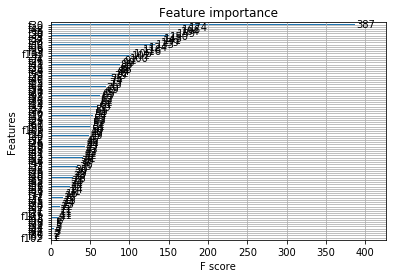

In [56]:
####################
# 训练得出测试结果
data['target'] = np.array(target)

loglossList = []
avglogloss = 0
foldNum = 1

day24 = data[data['day'] == 24]

day18_23 = data[data['day'] < 24]
day19_23 = day18_23[data['day'] >= 18]
# jius1print('18~23',list(day18_23))
dataTrain = day19_23.drop(['target'], axis=1)
labelTrain = day19_23['target']

dataTest = day24.drop(['target'], axis=1)
labelTest = day24['target']

logList = model.xgbEval(dataTrain, labelTrain, dataTest, labelTest, foldNum)
# logList = self.lgbEval(dataTrain, labelTrain, dataTest, labelTest, foldNum)
tmplogloss = np.min(np.array(logList))
avglogloss = avglogloss + tmplogloss
loglossList.append(logList)
# foldNum = foldNum + 1
avglogloss = avglogloss

In [61]:
####################
# 跑全量数据，得出提交集
baseline =  0.0787732
model_1 = solution('test')
ad_data_1 = model_1.readData()
ad_data_1 = model_1.convert_data(ad_data_1)
data_1, target_1 = model_1.datafilter(ad_data_1)

item_category_list_ing
item_property_list_ing
predict_category_property_ing_0
---------------------------
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num

G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.853476687842 41.455709224
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothUserCVR'] = PH_user_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.12520231044 55.2939856049
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.984594748331 48.457967926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.02853339139 50.9925884934
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.04772468487 52.8343365855
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
0.998830927426 51.0217884086
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\userIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothUserCVR'] = PH_user_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.28777367113 114.69545676
20day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothBrandCVR'] = PH_Brand_ID


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.16994820949 109.86178694
21day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.05518063183 103.43517261
22day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03308345807 102.114422124
23day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.03306416956 102.839059432
24day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
2.07192354781 105.500860638
25day
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\BrandIDBayesSmooth.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothBrandCVR'] = PH_Brand_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'sho

G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY19_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.99240079132 96.492758926
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY20_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.87392654619 92.7017838931
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY21_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89587730827 93.0289475579
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY22_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.88590609191 92.8673450753
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY23_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.89745111781 94.1775942228
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY24_data['SmoothShopCVR'] = PH_shop_id


['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description']
开始统计pos平滑
开始平滑操作
1.91197830814 95.8370424614
构建平滑转化率
开始复制保存


G:\notebook\SecretTianchiProject\src\util\shopIDBayesSmooth.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  DAY25_data['SmoothShopCVR'] = PH_shop_id
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['user_id_order'] = rnColumn['context_timestamp']


list =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sales_level', 'item_ID_sales_level', 'item_ID_collected_level', 'item_category_price_level', 'predict_category_property0', 'predict_category_property1', 'predict_category_property2', 'predict_category_property3', 'predict_category

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:466: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cnt1'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cnt1'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 data =  (539370, 76)
first list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id', 'item_category_sa

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['item_cvr_cntx'] = df2['item_id'].apply(lambda x: item_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cvr_cntx'] = df2['user_id'].apply(lambda x: user_cvr_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify

len1-1 Df2 =  (78261, 7)
len2-1 Df2 =  (149188, 7)
len2-1 Df2 =  (217572, 7)
len2-1 Df2 =  (288767, 7)
len2-1 Df2 =  (357082, 7)
len2-1 Df2 =  (420693, 7)
len2-1 Df2 =  (478111, 7)
len2-1 Df2 =  (539370, 7)
len3-1 Df2 =  (539370, 84)
second list data =  ['instance_id', 'item_id', 'item_category_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_property_list', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_age_level', 'user_star_level', 'user_occupation_id', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'time', 'day', 'hour', 'minute', 'user_query_day', 'user_query_day_hour', 'day_user_item_id', 'day_hour_minute_user_item_id', 'number_day_hour_item_id', 'number_user_id', 'number_shop_id', 'item_category_list_2', 'item_user_id', 'item_category_city_id',

G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_item_cnt2'] = df2[['item_id', 'user_id']].apply(lambda x: user_item_cnt.get(tuple(x), 0), axis=1)
G:\notebook\SecretTianchiProject\src\util\main_modify_val_modify_concat_add_lightgbm_add_day_eval_final_best.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df2['user_cnt2'] = df2['user_id'].apply(lambda x: user_cnt.get(x, 0))
G:\notebook\SecretTianchiProject\src\util\

len1 Df2 =  (78261, 7)
len2 Df2 =  (149188, 7)
len2 Df2 =  (217572, 7)
len2 Df2 =  (288767, 7)
len2 Df2 =  (357082, 7)
len2 Df2 =  (420693, 7)
len2 Df2 =  (478111, 7)
len2 Df2 =  (539370, 7)
len3 Df2 =  (539370, 7)
list Df2 ['user_item_cnt2', 'user_cnt2', 'item_cnt2', 'shop_cnt2', 'item_id', 'user_id', 'instance_id']
data shape (539370, 88)


ValueError: too many values to unpack (expected 2)

In [64]:
##########################
# 写提交集
writefileName = 'submits/17_20180421_pure.csv'
# print('11')
m = xgb.Booster(model_file='xgbModelFinal')
preds = m.predict(xgb.DMatrix(data_1.values))
sub = pd.DataFrame()
sub['instance_id'] = model_1.testInstanceID
sub['predicted_score'] = preds[-42888:]
sub.to_csv(writefileName, sep=" ", index=False, line_terminator='\r')


In [ ]:
import datetime
datetime.fromtimestamp('')

In [1]:
help(data_1.rank)

NameError: name 'data_1' is not defined